<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:white;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:left;vertical-align:top}
</style>


# 03 Extract the rind

Looking at individual fruit scans now, we can start segmenting the tissues of interest. 

- Exocarp
- Endocarp
- Rind
- Central column (spine)

Given the diversity of fruit shapes, and different scan qualities, I wasn't able to find a nice fully-automated solution.

- Instead, there I set a general process, a combination of basic image morphology operations in combination of some hyperparameters
- Manually set the hyperparameters for each fruit on a trial-and-error basis.

The order of the steps, _aka_ the order in which the tissues are extracted, had to be altered for some cases.
- Additional steps might also be required for other fruits

**Take this notebook as a _suggestion_ on how to extract tissues rather than an automated code**

<table class="tg">

<tbody>
  <tr>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_spine.gif" alt = "barley" style="width:175px;"/>
        <p style="text-align:center;font-size:20px"><strong>central column</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_endocarp.gif" alt = "barley" style="width:175px;"/>
        <p style="text-align:center;font-size:20px"><strong>endocarp</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_rind.gif" alt = "Website icon" style="width:175px;"/>
        <p style="text-align:center;font-size:20px"><strong>rind</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src="https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_exocarp.gif" alt="NSF Logo" style="width:175px">
        <p style="text-align:center;font-size:20px"><strong>exocarp</strong></p>
    </td>
  </tr>
</tbody>
</table>

In [2]:
import os
import sys
import glob
from importlib import reload

from matplotlib import pyplot as plt

import scipy.ndimage as ndimage
import scipy.spatial as spatial
import numpy as np
import pandas as pd

import tifffile as tf
import citrus_utils as vitaminC

### Load the whole (individual) fruit scan

- `rname` is the root name of the files (the use of _root_ bears no direct link with the botanical sense, but more of a computational/linguistic sense)
- It is `M02_CRC3812_12B-29-1_L02` in this case, which corresponds to a Som Keowan mandarin (see supplementary data)
- `lname` is the label of this specific replicate. 
- It is the `L02` replicate in this case
- This root and label will help us keep track of all the files related to this specific individual

### Where will tissues be saved?

- A new series of directories are automatically created (assuming they do not exist previously. If folders already exist, the folder creation step is skipped) in the `dst` path
- First a directory `rname` for each original raw scan
- Within an `lname` directory for each individual fruit

- Segmented tissue files follow the file names:
     
     `rname_lname_tissue.tif`

In [7]:
src = '../data/comps/'
init_dst = '../data/tissue/'
img_files = sorted(glob.glob(src+'*.tif'))

img_file = img_files[0]

_ , fname = os.path.split(img_file)
bname = os.path.splitext(fname)[0]


rname = '_'.join(bname.split('_')[:-1])
lname = bname.split('_')[-1]

dst = init_dst + rname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
dst += lname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)

img = tf.imread(img_file)
img_files

['../data/comps/M02_CRC3812_12B-29-1_L02.tif',
 '../data/comps/WR10_CRC0838_12A-5-5_L03.tif']

### See the distribution of densities

[(inf, None, 178), (234872, 106, 88), (38266, 139, 129), (5069, 128, 122), (329, 141, 140), (216, 125, 126), (3, 231, 232), (2, 42, 41), (2, 40, 39), (1, 229, 230), (0, 235, 254), (0, 233, 234)]
149


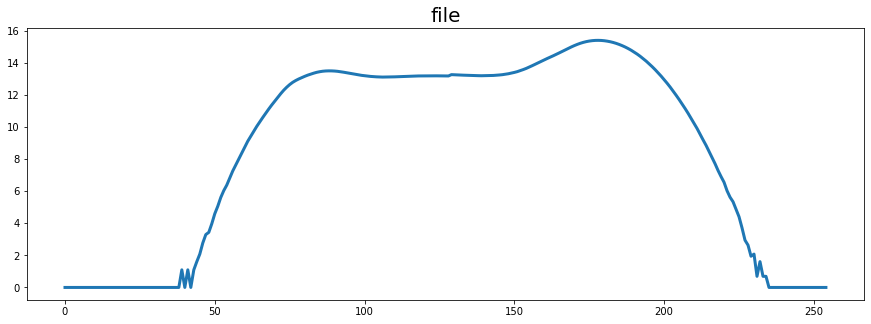

In [5]:
thr = vitaminC.get_individual_threshold(img, True)
print(thr)

### Clean clinging air

- Plotting a few slices of the mandarin reveals that there are air voxels (non-zero valued voxel which do not correspond to the fruit) lying in the central depressions
- This problem was observed in dumbbell-shaped fruits
    - The interior depressions "capture air"
    
To solve this problem

- Threshold out the air
- This thresholding might create artificial holes in the interior of the fruit
- Binarize the image
- For all 2D slices across the Y and Z directions (_but not_ X directions), fill in the holes of the binarized image
- We obtain a 3D mask with the same shape of the original mandarin _minus_ the central depressions.

In [8]:
thr = 100
rtholded = img.copy()
rtholded[rtholded < thr] = 0

In [9]:
fimg = vitaminC.fill_component(rtholded.copy(), x=False)
img *= fimg

Closed Y
Closed Z


## Get the rind

- The rind and the central column are of a noticeable lower density than the rest of the fruit
- Threshold out high density voxels
- "High" and "low" density are determined by the histogram above as a starting point
- Open the remaining voxels
    - There are usually air voxels clinging inside the irregularities of the skin
    - By opening the thresholded image, we remove this thin traces of air
    - Be careful to not remove actual fruit material, though
- Get just the largest single connected component
    - Any other components are usually very small in size and correspond to air and debris

In [10]:
thr = 148
rtholded = img.copy()
rtholded[rtholded > thr] = 0

In [11]:
size = 3
esize = (size, size, size)
orind = ndimage.grey_opening(rtholded, size=esize, mode='constant')
orind = ndimage.grey_opening(orind, size=esize, mode='constant')

orind = ndimage.grey_erosion(orind, size=esize, mode='constant')
#orind = ndimage.grey_erosion(orind, size=esize, mode='constant')

#orind = ndimage.grey_opening(orind, size=esize, mode='constant')

In [12]:
trind = vitaminC.get_largest_element(orind)

4279 components
[31484021     9955     9056     2139     1974     1374      985      917
      878      796      746      727      651      624      619      608
      571      563      556      555]


In [13]:
size = 4
struc = ndimage.generate_binary_structure(img.ndim, 2)
drind = ndimage.binary_dilation(trind, structure=struc, iterations=2)
drind = ndimage.binary_closing(drind, structure=struc, iterations=size)
#drind = ndimage.binary_opening(drind, structure=struc, iterations=size*2)
#drind = ndimage.binary_closing(drind, structure=struc, iterations=size)
#drind = ndimage.binary_opening(drind, structure=struc, iterations=size)
drind = ndimage.binary_dilation(drind, structure=struc, iterations=1)

In [14]:
rind = img*drind

2 2


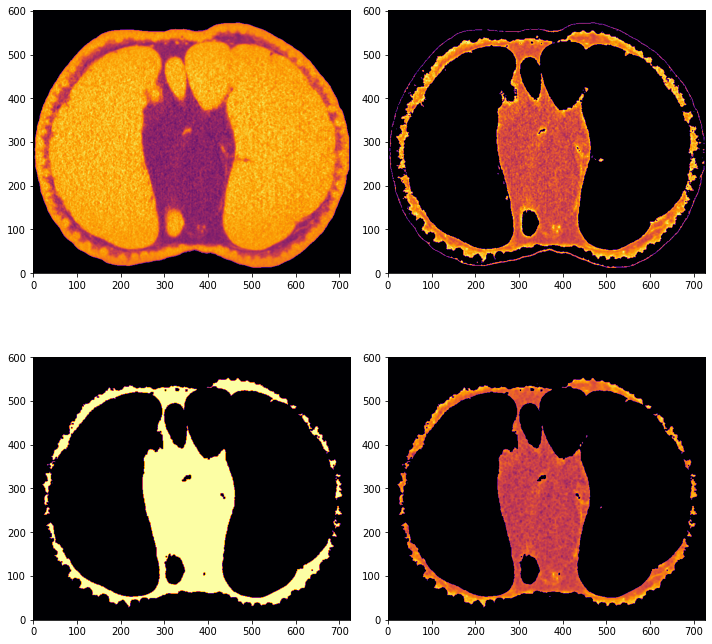

In [15]:
k = 418
ss = np.s_[:, k, :]
vitaminC.plot4x4panel([img, rtholded, trind, orind], ss, bname=bname)

### Visual inspection

- Toggle the thresholding and massage until satisfied
- Visually inspect the results
- Save the scan

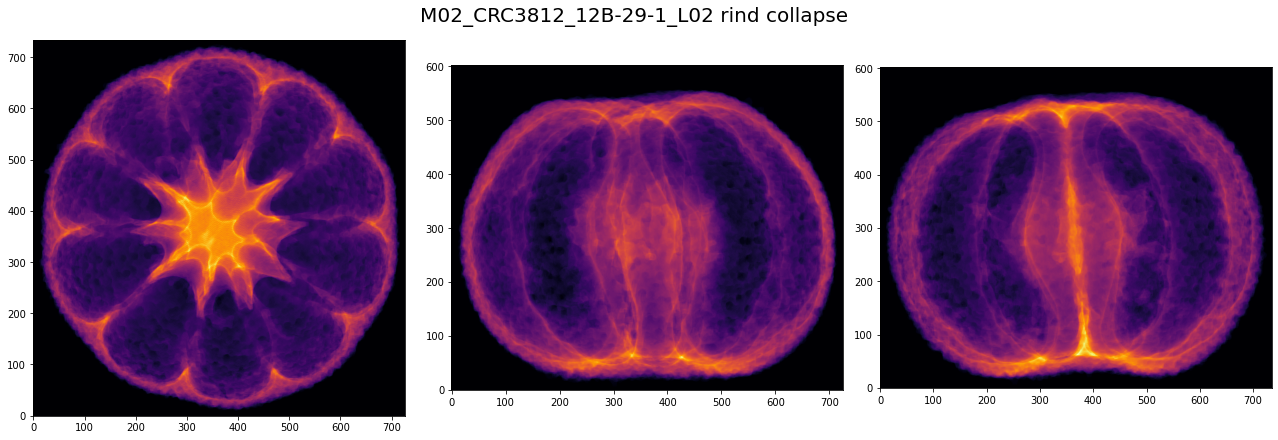

In [16]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(rind)
vitaminC.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

In [18]:
filename = dst + bname + '_rind.tif'
tf.imwrite(filename, rind, photometric='minisblack',compress=3)

## Get the endocarp

- The endocarp is a high-density tissue _contained_ by most of the rind
- Erode the whole fruit to scrap all the skin
- Once the skin has been scrapped, remove the rind
- Whatever is left, the largest remaining connected component should be the endocarp
- Dilate a bit the endocarp in case we over-scrubbed before

In [29]:
rind = tf.imread(dst + bname + '_rind.tif')
cendo = rind.copy()
cendo[cendo > 0] = 1

eimg = img.copy()
eimg = ndimage.grey_erosion(img, size=(15,15,15), mode='constant')

In [30]:
eimg = ndimage.grey_erosion(eimg, size=(15,15,15), mode='constant')
eimg = ndimage.grey_erosion(eimg, size=(9,9,9), mode='constant')
eimg = ndimage.grey_erosion(eimg, size=(3,3,3), mode='constant')
eimg = ndimage.grey_erosion(eimg, size=(15,15,15), mode='constant')

In [21]:
#eimg = ndimage.grey_erosion(eimg, size=(15,15,15), mode='constant')
#eimg = ndimage.grey_erosion(eimg, size=(15,15,15), mode='constant')

In [31]:
dendo = eimg.copy()
dendo[dendo > 0] = 1

endocarp = img*dendo*(1-cendo)
#endocarp[endocarp < 100] = 0

In [32]:
dendo = endocarp.copy()
dendo[dendo > 0] = 1

dendo = ndimage.grey_closing(dendo, size=(15,15,15), mode='constant')
dendo = ndimage.grey_closing(dendo, size=(15,15,15), mode='constant')
dendo = ndimage.grey_closing(dendo, size=(9,9,9), mode='constant')
dendo = ndimage.grey_opening(dendo, size=(15,15,15), mode='constant')

In [33]:
tendo = vitaminC.get_largest_element(dendo)
#tendo = vitaminC.get_largest_element(endocarp)

1 components
[98512632]


In [34]:
dendo = ndimage.grey_dilation(tendo, size=(9,9,9), mode='constant')

In [35]:
endocarp = img*dendo

2 2


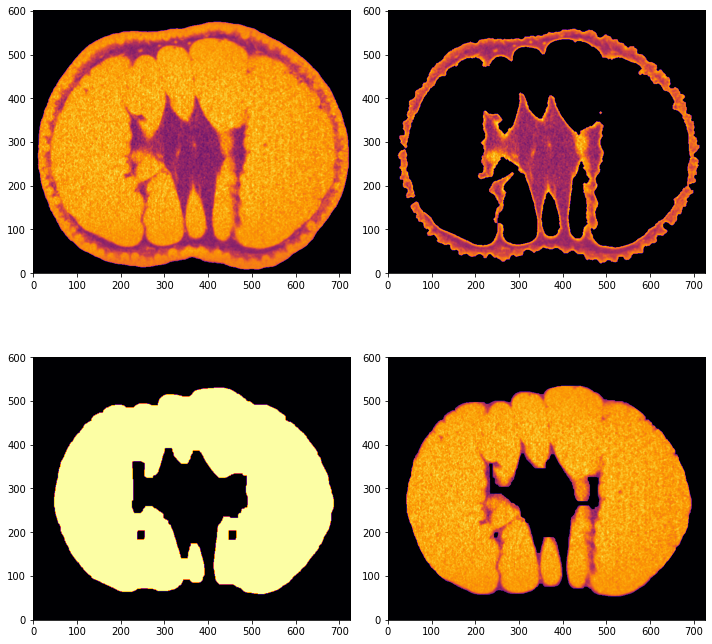

In [36]:
k = 450
ss = np.s_[:, k, :]
vitaminC.plot4x4panel([img, rind, tendo, endocarp], ss, bname=bname)

### Another visual inspection

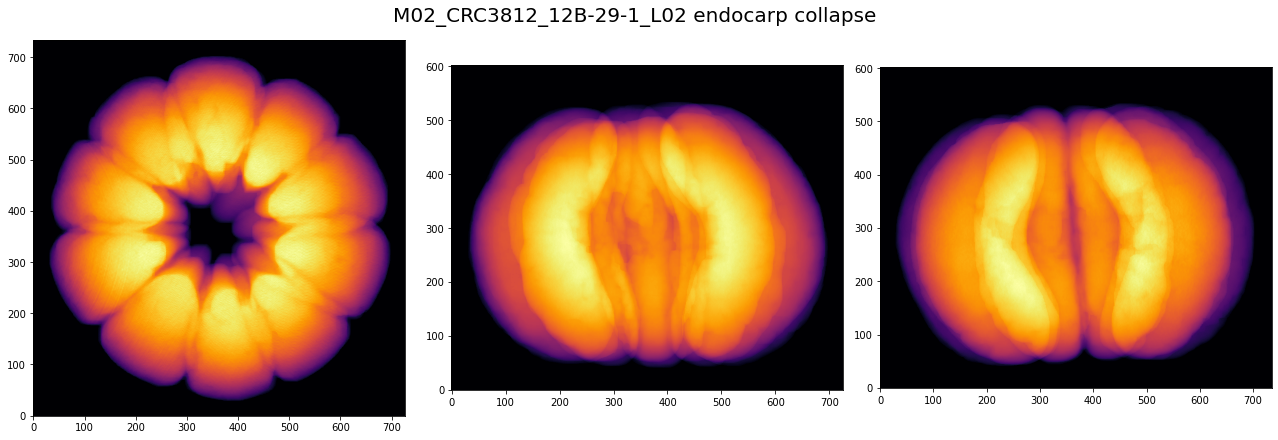

In [37]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(endocarp)
vitaminC.plot_collapse_dimensions(snaps, bname, 'endocarp', display=display, writefig=writefig, dst=diag_dst)

In [38]:
filename = dst + bname + '_endocarp.tif'
tf.imwrite(filename, endocarp, photometric='minisblack',compress=3)

## Get the exocarp

- The exocarp is also high density
- Merge the rind and the endocarp in a single component
- Fill in all the interior holes of this new component
- Remove that component from the original fruit
- The largest component remaining should be the skin

In [47]:
dendo = tf.imread(dst + bname + '_endocarp.tif')
dendo[dendo > 0] = 1

dendo = ndimage.binary_dilation(dendo, iterations=2, structure=struc).astype(np.uint8)

drind = tf.imread(dst + bname + '_rind.tif')
drind[drind > 0] = 1

drind = ndimage.binary_erosion(drind, iterations=5, structure=struc).astype(np.uint8)

comp = drind + dendo - drind*dendo
comp = comp.astype(np.uint8)

In [48]:
#rcomp = vitaminC.fill_component(comp)
rcomp = ndimage.binary_fill_holes(comp)

In [49]:
tendo = img*(1-rcomp)
tendo[tendo < thr] = 0
tendo[tendo > 0] = 1

In [50]:
tendo = ndimage.binary_closing(tendo, iterations=2, structure=struc)
texo = vitaminC.get_largest_element(tendo)

4511 components
[29167548      281      279      267      265      254      193      180
      164      118       99       99       81       79       74       70
       69       66       62       59]


In [51]:
eimg = ndimage.binary_dilation(texo, iterations=2, structure=struc)

In [52]:
exocarp = img*eimg

2 2


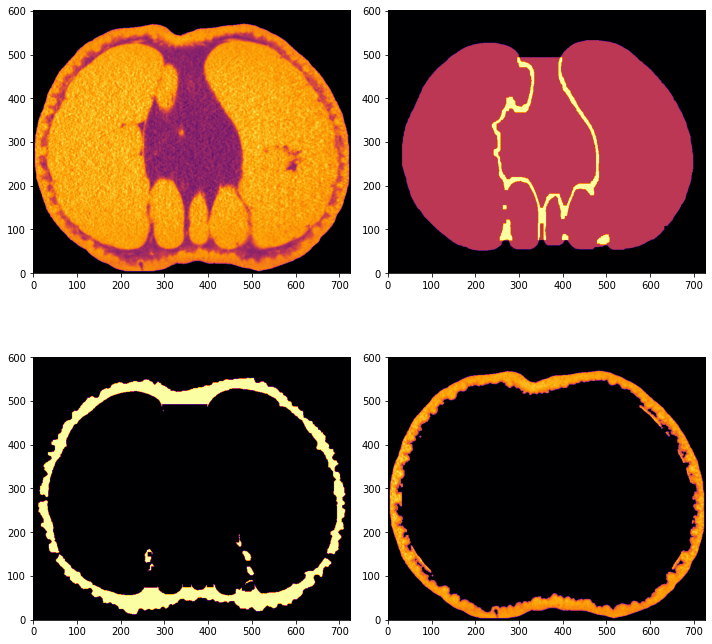

In [69]:
k = 300
ss = np.s_[:, k, :]
vitaminC.plot4x4panel([img, drind+dendo, tendo, exocarp], ss, bname=bname)

### Visual check and save the skin

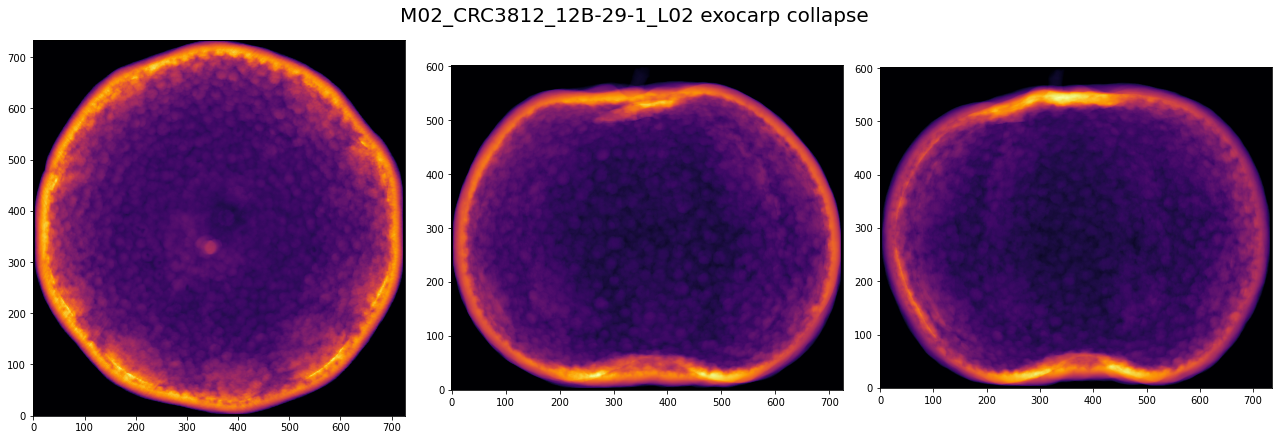

In [54]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(exocarp)
vitaminC.plot_collapse_dimensions(snaps, bname, 'exocarp', display=display, writefig=writefig, dst=diag_dst)

In [56]:
filename = dst + bname + '_exocarp.tif'
tf.imwrite(filename, exocarp, photometric='minisblack',compress=3)

## Get the spine or central column

- The central column is surrounded by the endocarp
- Fill in all the central hole bounded by the endocarp
- Get this hole as the spine

### Get the mesocarp

- The mesocarp is just the rind minus the central column
- There is no need to save the mesocarp as an individual tissue if the rind is stored

In [57]:
dendo = endocarp.copy()
dendo[dendo > 0] = 1

endo = vitaminC.fill_component(dendo)

Closed X
Closed Y
Closed Z


In [58]:
size = 9
esize = (size-4, size, size)

eendo = ndimage.grey_erosion(endo, size=esize, mode='constant')

tspine = rind*eendo
tspine = vitaminC.get_largest_element(tspine)

7334 components
[15951280     3534     3426     3184     3002     2889     2649     2543
     2141     1971     1859     1769     1507     1443     1429     1320
     1282     1131     1103     1079]


In [59]:
eesize = (3*(size+2), size+2, size+2)
drind = ndimage.grey_opening(tspine, size=(8,8,8), mode='constant')
#eesize = (3*size, 1, 1)
#tspine = ndimage.grey_dilation(tspine, size=eesize, mode='constant')

In [60]:
tspine = vitaminC.get_largest_element(drind)

93 components
[14121757    29903    27128    12761    12002    10809    10241     9384
     9096     8514     7930     7622     7214     7042     6677     6427
     6132     5888     5565     5441]


In [61]:
spine = rind*tspine
mesocarp = rind*(1-tspine)

In [62]:
tendo = vitaminC.get_largest_element(mesocarp)

6934 components
[34847283    16532    14806    14432     7744     5133     4434     4113
     3765     3763     3654     3474     3452     3425     3367     3328
     3014     2998     2858     2784]


In [63]:
mesocarp *= tendo

2 2


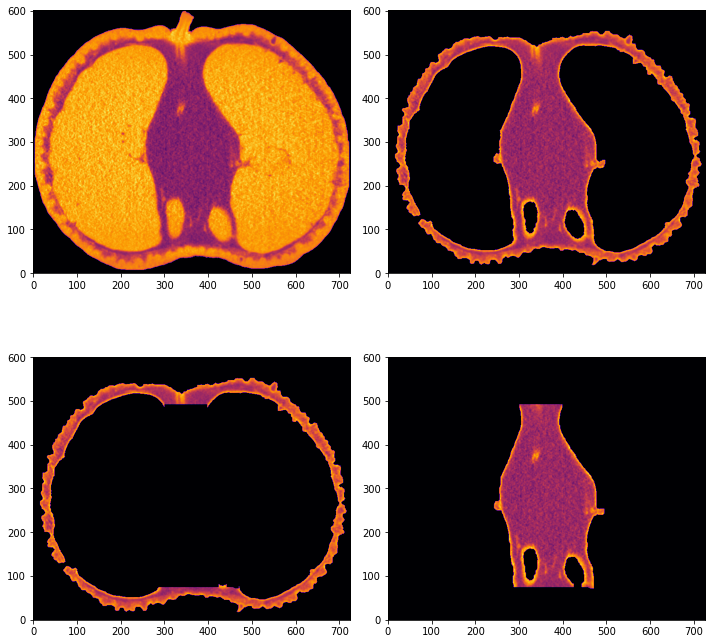

In [65]:
k = 326
ss = np.s_[:, k, :]
vitaminC.plot4x4panel([img, rind, mesocarp, spine], ss, bname=bname)

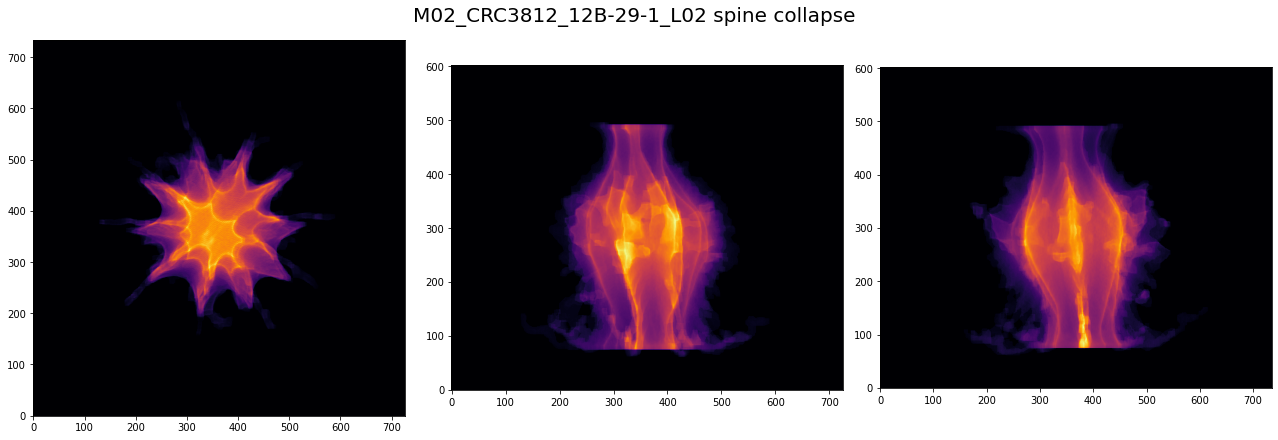

In [66]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(spine)
vitaminC.plot_collapse_dimensions(snaps, bname, 'spine', display=display, writefig=writefig, dst=diag_dst)

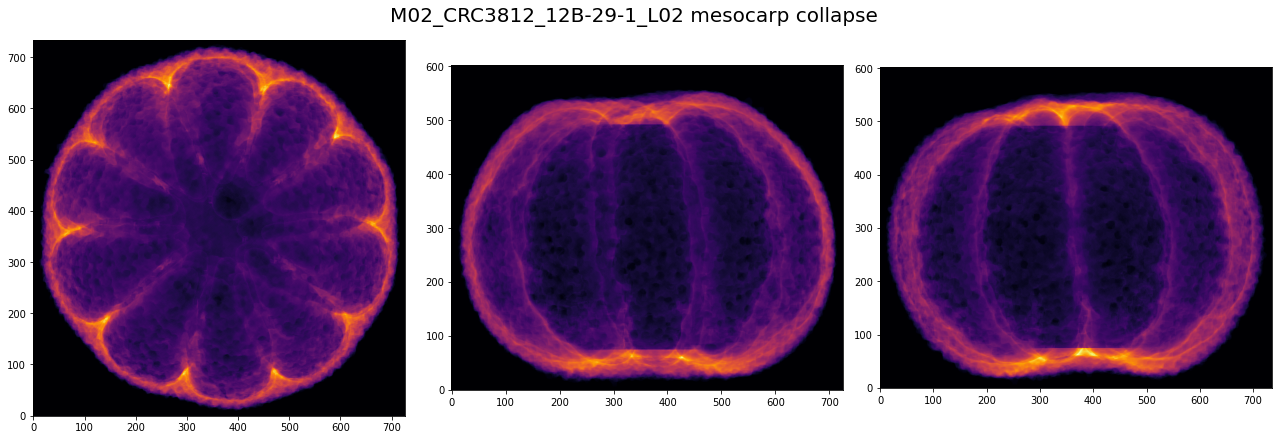

In [67]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(mesocarp)
vitaminC.plot_collapse_dimensions(snaps, bname, 'mesocarp', display=display, writefig=writefig, dst=diag_dst)

In [68]:
filename = dst + bname + '_spine.tif'
tf.imwrite(filename, spine, photometric='minisblack',compress=3)